# Advanced Machine Learning course IBM

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
    
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

PermissionError: [Errno 13] Permission denied: '/opt/spark/./bin/spark-submit'

## Preparing the dataset

In [1]:
# download accelerometer dataset
!git clone https://github.com/wchill/HMP_Dataset.git

Cloning into 'HMP_Dataset'...
remote: Enumerating objects: 865, done.
remote: Total 865 (delta 0), reused 0 (delta 0), pack-reused 865
Receiving objects: 100% (865/865), 1010.96 KiB | 6.56 MiB/s, done.


In [3]:
!ls HMP_Dataset

Brush_teeth	Drink_glass  Getup_bed	  Pour_water	 Use_telephone
Climb_stairs	Eat_meat     impdata.py   README.txt	 Walk
Comb_hair	Eat_soup     Liedown_bed  Sitdown_chair
Descend_stairs	final.py     MANUAL.txt   Standup_chair


In [52]:
# import data file. Txt with 3 features, separated by space
from pyspark.sql.types import StructType, StructField, IntegerType

schema = StructType([
    StructField("x", IntegerType(), True),
    StructField("y", IntegerType(), True),
    StructField("z", IntegerType(), True)
])

import os
file_list = os.listdir("HMP_Dataset")

# keep only relevant folders
file_list_filtered = [file for file in file_list if "." not in file]
file_list_filtered

['Comb_hair',
 'Brush_teeth',
 'Climb_stairs',
 'Standup_chair',
 'Eat_soup',
 'Use_telephone',
 'Sitdown_chair',
 'Descend_stairs',
 'Getup_bed',
 'Eat_meat',
 'Pour_water',
 'Drink_glass',
 'Liedown_bed',
 'Walk']

In [53]:
# prepare a Spark dataframe for each category
df = None

from pyspark.sql.functions import lit

for category in file_list_filtered:
    data_files = os.listdir("HMP_Dataset/"+category)
    for data_file in data_files:
        temp_df = spark.read.option("header", "false").option("delimiter", " ").csv("HMP_Dataset/"+category+"/"+data_file, schema=schema)
        
        temp_df = temp_df.withColumn("class", lit(category)) # create a feature with the class for each measurement
        
        temp_df = temp_df.withColumn("source", lit(data_file)) # create a feature with the source file originating each measurement
        
        if df is None:
            df = temp_df
        else:
            df = df.union(temp_df)
    

In [54]:
df.show()

+---+---+---+---------+--------------------+
|  x|  y|  z|    class|              source|
+---+---+---+---------+--------------------+
| 33| 37| 53|Comb_hair|Accelerometer-201...|
| 33| 37| 53|Comb_hair|Accelerometer-201...|
| 35| 36| 52|Comb_hair|Accelerometer-201...|
| 34| 37| 53|Comb_hair|Accelerometer-201...|
| 35| 37| 51|Comb_hair|Accelerometer-201...|
| 34| 38| 52|Comb_hair|Accelerometer-201...|
| 33| 38| 51|Comb_hair|Accelerometer-201...|
| 34| 38| 52|Comb_hair|Accelerometer-201...|
| 35| 37| 51|Comb_hair|Accelerometer-201...|
| 33| 39| 52|Comb_hair|Accelerometer-201...|
| 33| 37| 52|Comb_hair|Accelerometer-201...|
| 33| 37| 53|Comb_hair|Accelerometer-201...|
| 34| 37| 52|Comb_hair|Accelerometer-201...|
| 34| 38| 52|Comb_hair|Accelerometer-201...|
| 34| 38| 52|Comb_hair|Accelerometer-201...|
| 34| 38| 52|Comb_hair|Accelerometer-201...|
| 34| 39| 52|Comb_hair|Accelerometer-201...|
| 35| 37| 52|Comb_hair|Accelerometer-201...|
| 33| 38| 51|Comb_hair|Accelerometer-201...|
| 34| 39| 

22/01/31 17:58:28 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


In [55]:
# prepare data for OneHotEncoding - have class (string names) transformed into indexes
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol = "class", outputCol = "classIndex")
indexed = indexer.fit(df).transform(df)
indexed.show()

22/01/31 17:58:44 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/01/31 18:00:23 WARN DAGScheduler: Broadcasting large task binary with size 1390.4 KiB


+---+---+---+---------+--------------------+----------+
|  x|  y|  z|    class|              source|classIndex|
+---+---+---+---------+--------------------+----------+
| 33| 37| 53|Comb_hair|Accelerometer-201...|       9.0|
| 33| 37| 53|Comb_hair|Accelerometer-201...|       9.0|
| 35| 36| 52|Comb_hair|Accelerometer-201...|       9.0|
| 34| 37| 53|Comb_hair|Accelerometer-201...|       9.0|
| 35| 37| 51|Comb_hair|Accelerometer-201...|       9.0|
| 34| 38| 52|Comb_hair|Accelerometer-201...|       9.0|
| 33| 38| 51|Comb_hair|Accelerometer-201...|       9.0|
| 34| 38| 52|Comb_hair|Accelerometer-201...|       9.0|
| 35| 37| 51|Comb_hair|Accelerometer-201...|       9.0|
| 33| 39| 52|Comb_hair|Accelerometer-201...|       9.0|
| 33| 37| 52|Comb_hair|Accelerometer-201...|       9.0|
| 33| 37| 53|Comb_hair|Accelerometer-201...|       9.0|
| 34| 37| 52|Comb_hair|Accelerometer-201...|       9.0|
| 34| 38| 52|Comb_hair|Accelerometer-201...|       9.0|
| 34| 38| 52|Comb_hair|Accelerometer-201...|    

22/01/31 18:00:41 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


In [56]:
# One Hot Encoding - a vector into a matrix of 0 and 1's for each class
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCol = "classIndex", outputCol = "catVectors")
encoded = encoder.fit(indexed).transform(indexed) 
encoded.show()

+---+---+---+---------+--------------------+----------+--------------+
|  x|  y|  z|    class|              source|classIndex|    catVectors|
+---+---+---+---------+--------------------+----------+--------------+
| 33| 37| 53|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|
| 33| 37| 53|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|
| 35| 36| 52|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|
| 34| 37| 53|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|
| 35| 37| 51|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|
| 34| 38| 52|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|
| 33| 38| 51|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|
| 34| 38| 52|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|
| 35| 37| 51|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|
| 33| 39| 52|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|
| 33| 37| 52|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|
| 33| 

22/01/31 18:00:56 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


In [57]:
# transform x, y, z into vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

vectorAssembler = VectorAssembler(inputCols = ["x","y","z"], outputCol = "features")
features_vectorized = vectorAssembler.transform(encoded)
features_vectorized.show()

+---+---+---+---------+--------------------+----------+--------------+----------------+
|  x|  y|  z|    class|              source|classIndex|    catVectors|        features|
+---+---+---+---------+--------------------+----------+--------------+----------------+
| 33| 37| 53|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|[33.0,37.0,53.0]|
| 33| 37| 53|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|[33.0,37.0,53.0]|
| 35| 36| 52|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|[35.0,36.0,52.0]|
| 34| 37| 53|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|[34.0,37.0,53.0]|
| 35| 37| 51|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|[35.0,37.0,51.0]|
| 34| 38| 52|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|[34.0,38.0,52.0]|
| 33| 38| 51|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|[33.0,38.0,51.0]|
| 34| 38| 52|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|[34.0,38.0,52.0]|
| 35| 37| 51|Comb_hair|Accelerom

22/01/31 18:01:13 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


In [58]:
## normalization (if needed)
# from pyspark.ml.feature import Normalizer
# normalizer = Normalizer(inputCol="features", outputCol = "features_norm", p=1.0)
# normalized_data = normalizer.transform(features_vectorized)
# normalized_data.show()


## SparkML - pipelines

In [59]:
# creating a pipeline of these steps
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[indexer,encoder,vectorAssembler]) # I did not put the Normalizer this time, as the data does not really need it and it might be counter-productive
model = pipeline.fit(df)
prediction = model.transform(df)
prediction.show() # this has to be the same as the output from the features_vectorized (as my pipeline runs the df dataframe until this stage)


22/01/31 18:01:27 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/01/31 18:04:38 WARN DAGScheduler: Broadcasting large task binary with size 1390.4 KiB


+---+---+---+---------+--------------------+----------+--------------+----------------+
|  x|  y|  z|    class|              source|classIndex|    catVectors|        features|
+---+---+---+---------+--------------------+----------+--------------+----------------+
| 33| 37| 53|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|[33.0,37.0,53.0]|
| 33| 37| 53|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|[33.0,37.0,53.0]|
| 35| 36| 52|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|[35.0,36.0,52.0]|
| 34| 37| 53|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|[34.0,37.0,53.0]|
| 35| 37| 51|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|[35.0,37.0,51.0]|
| 34| 38| 52|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|[34.0,38.0,52.0]|
| 33| 38| 51|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|[33.0,38.0,51.0]|
| 34| 38| 52|Comb_hair|Accelerometer-201...|       9.0|(13,[9],[1.0])|[34.0,38.0,52.0]|
| 35| 37| 51|Comb_hair|Accelerom

22/01/31 18:04:53 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


In [62]:
# get rid of the non-useful features/columns

df_train = prediction.drop("x").drop("y").drop("z").drop("class").drop("source").drop("classIndex")
df_train.show()

22/01/31 21:17:31 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


+--------------+----------------+
|    catVectors|        features|
+--------------+----------------+
|(13,[9],[1.0])|[33.0,37.0,53.0]|
|(13,[9],[1.0])|[33.0,37.0,53.0]|
|(13,[9],[1.0])|[35.0,36.0,52.0]|
|(13,[9],[1.0])|[34.0,37.0,53.0]|
|(13,[9],[1.0])|[35.0,37.0,51.0]|
|(13,[9],[1.0])|[34.0,38.0,52.0]|
|(13,[9],[1.0])|[33.0,38.0,51.0]|
|(13,[9],[1.0])|[34.0,38.0,52.0]|
|(13,[9],[1.0])|[35.0,37.0,51.0]|
|(13,[9],[1.0])|[33.0,39.0,52.0]|
|(13,[9],[1.0])|[33.0,37.0,52.0]|
|(13,[9],[1.0])|[33.0,37.0,53.0]|
|(13,[9],[1.0])|[34.0,37.0,52.0]|
|(13,[9],[1.0])|[34.0,38.0,52.0]|
|(13,[9],[1.0])|[34.0,38.0,52.0]|
|(13,[9],[1.0])|[34.0,38.0,52.0]|
|(13,[9],[1.0])|[34.0,39.0,52.0]|
|(13,[9],[1.0])|[35.0,37.0,52.0]|
|(13,[9],[1.0])|[33.0,38.0,51.0]|
|(13,[9],[1.0])|[34.0,39.0,51.0]|
+--------------+----------------+
only showing top 20 rows



# Machine learning in SparkML

In [64]:
# split data into train and test sets
splits = df_train.randomSplit([0.8,0.2])
df_tr = splits[0]
df_test = splits[1]

In [70]:
#linear regression
from pyspark.ml.regression import LinearRegression

# logistic regression
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter = 10, regParam = 0.3, elasticNetParam = 0.8)

# support vector machine
from pyspark.ml.classification import LinearSVC
svc = LinearSVC(maxIter = 10, regParam = 0.1)

# Grid Search


## Unsupervised Learning
# Clustering - K means
from pyspark.ml.clustering import KMeans
kmeans = KMeans().setK(13).setSeed(1)



from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[indexer,encoder,vectorAssembler, lr]) # add the regression/classification step here
model = pipeline.fit(df_train)
prediction = model.transform(df_train)
prediction.show()

from pyspark.ml.evaluation import MultiClassificationEvaluator
evaluat = MultiClassificationEvaluator().setMetricName('accuracy').setLabelCol('label').setPredictionCol('prediction')
evaluat.evaluate(prediction) # then we can see the accuracy


# Signals processing

In [99]:
# Fourier Transform decomposes the signal into the frequencies it is made of
# example, when playing piano, we normally play a combination of notes to generate a sound.
# Fourier transform would be able to, from this combined sound, extract which individual notes were played together to make up this sound.

# visualization of signals
import numpy as np
import matplotlib.pyplot as plt

def gen_wave(freq, amp, T, shift, sr):  # sr means sampling rate
    time = np.arange(0,T,T/sr)
    X = amp*np.sin(2*np.pi*freq*time + shift) # formula to generate any signal
    return time, X

time, amplitude = gen_wave(5,5,1,0,1000)

def plot_signal(time, amplitude):
    font = {'weight' : 'normal',
        'size'   : 16}
    plt.rc('font', **font)
    # plt.rcParams['xtick.labelsize'] = 16
    # plt.rcParams.update({'font.size': 16})

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_axes([0,0,1,1])
    ax.plot(time, amplitude, c="b")
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.grid(True, which="both")
    plt.show()

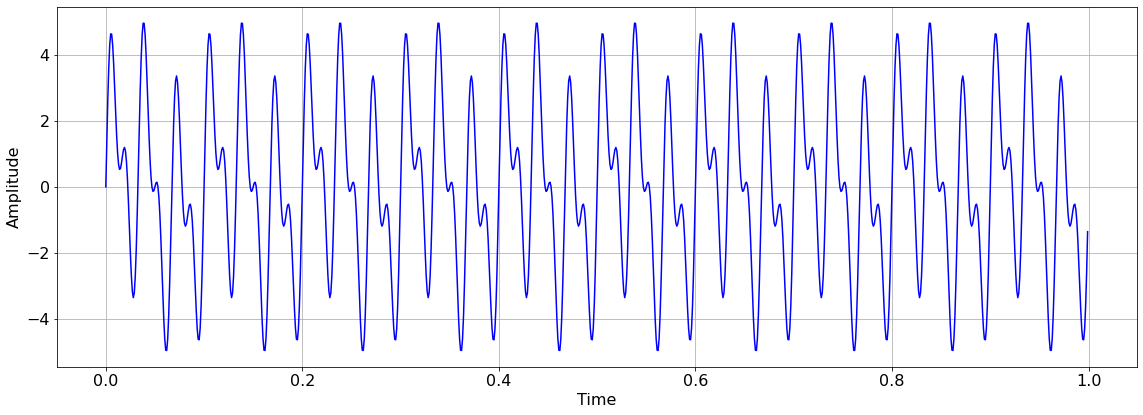

In [124]:
# run a combination of signals:
amplitude_combined = gen_wave(1,1,10,0,1000)[1] + gen_wave(3,3,10,0,1000)[1] + gen_wave(6,2,10,0,1000)[1]
plot_signal(time, amplitude_combined)

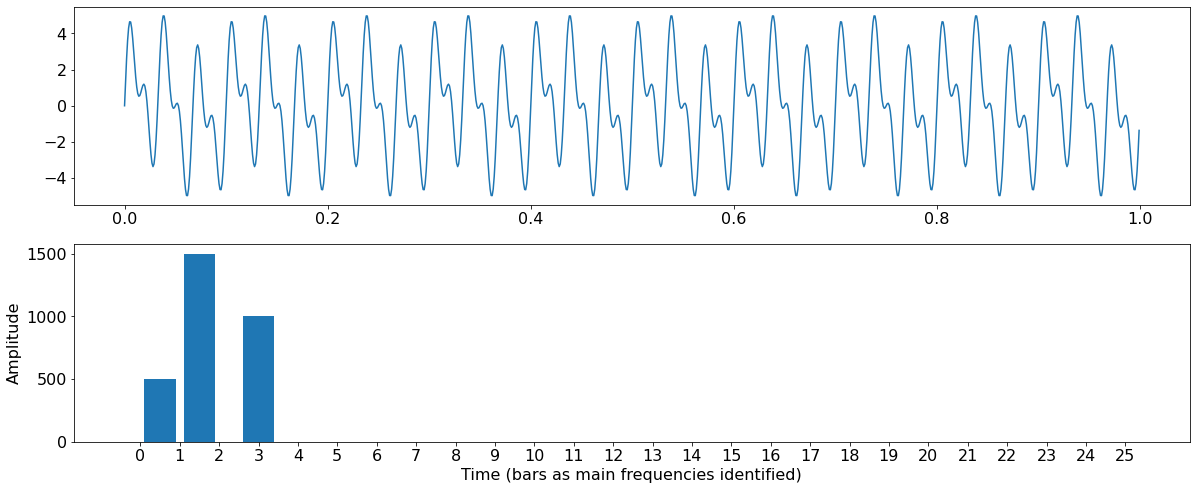

In [125]:
# processing with fourier transform
import math
from numpy.fft import fft
sr = 50 # in Hz
n = len(amplitude_combined)
p = fft(amplitude_combined)

f, axarr = plt.subplots(2, figsize = (20,8))

mag = np.sqrt(p.real**2 + p.imag**2)
mag = mag[0:math.ceil((n)/2.0)]
x = np.arange(0, len(mag), 1.0)* (sr/n)

axarr[0].plot(time, amplitude_combined)
axarr[1].bar(x,mag)
axarr[1].xaxis.set_ticks(np.arange(min(x), max(x)+1,1.0));
plt.xlabel("Time (bars as main frequencies identified)")
plt.ylabel("Amplitude");

# note: the graph in the bottom represents the main frequencies identified and their relative amplitude as the height of the bar